# Problem Statement: **Stock Movement Prediction using Spectrograms, Technical Indicators and News**

This code file - named as 1_spectrograms.ipynb contains all the code related to the work done using spectrograms to predict stock prices. We have chosen the bank - AU Small Finance Bank Ltd
(stock symbol - AUBANK) for our experiment.

# **Importing Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset

import numpy as np
import pandas as pd

from scipy import signal
import matplotlib.pyplot as plt
from PIL import Image

import os
import warnings

## **Checking GPU Information**

In [2]:
print("The number of available GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("The GPU device:", torch.cuda.get_device_name(0))

The number of available GPUs: 1
The GPU device: NVIDIA GeForce GTX 1050 Ti


# **Loading the Dataset**

In [3]:
stock_symbol = 'AUBANK.NS'
start_date = "2017-01-01"
end_date = "2022-12-31"

In [4]:
aubank_data = pd.read_csv(f'{stock_symbol}.csv')

In [5]:
aubank_data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_9,SMA_21,EMA_9,...,BB_lower,ADX,ADX+DI,ADX-DI,CMF,OBV,CCI,Williams_%R,ATR,Target
0,2017-08-29,265.500000,279.399994,265.500000,272.399994,270.861786,1649802,268.661109,275.953571,269.747170,...,257.109623,46.315878,15.579860,27.511465,0.182936,-7916212.0,-22.486667,-43.905643,11.294367,0.00
1,2017-08-30,275.000000,278.875000,274.225006,275.424988,273.869659,712294,269.036109,275.057142,270.882733,...,258.701281,44.629755,14.862239,26.244265,0.162639,-7203918.0,24.239067,-22.460356,10.919995,0.53
2,2017-08-31,274.899994,278.225006,273.000000,274.725006,273.173615,580208,269.366665,274.077381,271.651188,...,260.456179,43.268357,14.290231,26.136532,0.141817,-7784126.0,30.892280,-16.461228,10.480352,0.50
3,2017-09-01,275.500000,285.000000,273.774994,276.149994,274.590576,1765988,270.174998,273.277380,272.550949,...,262.568087,40.724434,18.056729,23.999530,0.124248,-6018138.0,96.957914,-36.875025,10.537509,0.51
4,2017-09-04,277.875000,282.149994,271.024994,278.500000,276.927307,1182770,271.108331,272.682142,273.740759,...,262.630387,38.798966,16.607432,24.057285,0.144057,-4835368.0,88.353220,-27.083333,10.582363,0.52
5,2017-09-05,280.049988,288.250000,276.575012,286.575012,284.956726,1989224,273.533332,273.030952,276.307610,...,261.445038,36.017884,19.571585,22.056518,0.186246,-2846144.0,177.568397,-6.146744,10.665375,0.57
6,2017-09-06,284.000000,289.000000,281.799988,283.924988,282.321686,1157354,275.899997,273.353571,277.831085,...,260.914892,33.384987,19.092384,20.902004,0.166896,-4003498.0,160.379632,-18.125044,10.403286,0.48
7,2017-09-07,285.625000,288.000000,277.500000,279.350006,277.772491,815452,277.336110,273.527380,278.134870,...,261.370567,31.613485,17.642099,22.425050,0.090621,-4818950.0,117.262176,-34.464264,10.410570,0.47
8,2017-09-08,280.500000,282.750000,275.000000,277.174988,275.609802,831916,278.247220,273.194047,277.942893,...,261.367084,30.339722,16.637531,22.984957,0.036877,-5650866.0,67.870040,-42.232186,10.210966,0.49
9,2017-09-11,279.375000,282.450012,275.500000,279.299988,277.722839,697004,279.013885,273.401188,278.214312,...,261.489833,29.181880,15.770295,21.786860,0.068276,-4953862.0,69.590690,-34.642901,9.967196,0.52


In [6]:
print("The shape of the dataset: ", aubank_data.shape)

The shape of the dataset:  (1322, 30)


# **Function to Generate and Save Spectrograms**

In [7]:
def save_spectrogram(prices, name, output_dir):
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        
        detrended = signal.detrend(prices)
        f, t, Sxx = signal.stft(detrended, fs=1, nperseg=512, nfft=1024)
    
    plt.figure(figsize=(4, 4))
    plt.pcolormesh(t, f, np.abs(Sxx), shading='gouraud')
    plt.ylim(0, 0.01)
    plt.axis('off')
    
    temp_path = os.path.join(output_dir, f"{name}_temp.png")
    plt.savefig(temp_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    with Image.open(temp_path) as img:
        img = img.resize((224, 224)).convert('RGB')
        output_path = os.path.join(output_dir, f"{name}.png")
        img.save(output_path)
    
    os.remove(temp_path)

# **Obtaining Relevant Data Used for Making Spectrograms**

In [8]:
number_of_days = 30

In [9]:
close_prices = aubank_data['Close'].values
open_prices = aubank_data['Open'].values
high_prices = aubank_data['High'].values
low_prices = aubank_data['Low'].values
volumes = aubank_data['Volume'].values
labels = aubank_data['Target'].values
dates = aubank_data['Date'].values

In [10]:
aubank_data = aubank_data.drop(0)
labels = labels[1:]
close_prices = close_prices[1:]
open_prices = open_prices[1:]
high_prices = high_prices[1:]
low_prices = low_prices[1:]
volumes = volumes[1:]
dates = dates[1:]

In [11]:
aubank_data_maximum = (60.20001220703125, 82.07501220703125)
aubank_max_rise, aubank_max_fall = aubank_data_maximum

In [12]:
split_index = int(0.8 * (len(close_prices) - number_of_days))

In [13]:
print("The number of training samples:", split_index)

The number of training samples: 1032


In [14]:
actual_close_prices = close_prices[split_index-1:]

In [15]:
old_close = close_prices[split_index-1]
print("The old close price:", old_close)

The old close price: 622.5750122070312


# **Generating and Storing Train and Test Labels**

In [16]:
train_labels = []
test_labels = []

In [17]:
for i in range(len(close_prices) - number_of_days):

    label = labels[i + number_of_days]
    
    if i < split_index:
        train_labels.append(label)
    else:
        test_labels.append(label)

In [18]:
np.save('labels/train_labels.npy', train_labels)
np.save('labels/test_labels.npy', test_labels)

# **Functions for Saving Images and Visualisation Purposes**

## **Function to Store Images based on the Approach**

In [19]:
def make_spectrogram_dataset(approach, output_dir_train, output_dir_test, number_of_days):

    for i in range(len(close_prices) - number_of_days):
        
        if(approach == 1):
            window_data = close_prices[i:i + number_of_days]
            if i < split_index:
                save_spectrogram(window_data, name=i + 1, output_dir=output_dir_train)
            else:
                save_spectrogram(window_data, name=i + 1, output_dir=output_dir_test)
        
        elif(approach == 2):
            windowed_close_prices = []
            windows = [5, 10, 15, 20, 25, 30]

            for window in windows:
                windowed_close_prices.append(close_prices[i + number_of_days - window: i + number_of_days])

            windowed_close_prices = np.concatenate(windowed_close_prices, axis=0)

            if i < split_index:
                save_spectrogram(windowed_close_prices, name=i+1, output_dir=output_dir_train)

            else:
                save_spectrogram(windowed_close_prices, name=i+1, output_dir=output_dir_test)

        elif(approach == 3):
            window_data = np.concatenate([
                open_prices[i:i+number_of_days],
                high_prices[i:i+number_of_days],
                low_prices[i:i+number_of_days],
                close_prices[i:i+number_of_days],
                volumes[i:i+number_of_days]
            ])
            
            if i < split_index:
                save_spectrogram(window_data, name=i + 1, output_dir=output_dir_train)
            else:
                save_spectrogram(window_data, name=i + 1, output_dir=output_dir_test)

        else:
            print("Invalid approach")
            break


        if i % 100 == 0:
            print(f"Processed {i}/{len(close_prices) - number_of_days} windows")
    
        if(i == len(close_prices) - number_of_days - 1):
            print("All windows processed and stored.")

## **Function to Plot Spectrograms for Visualisation Purpose**

In [20]:
def plot_sample_spectrograms(approach, output_dir):

    fig, axs = plt.subplots(3, 3, figsize=(10, 10))

    for i in range(9):
        img = Image.open(f"{output_dir}/{i+1}.png")
        axs[i//3, i%3].imshow(img)
        axs[i//3, i%3].set_title(f"Image: {i+1}.jpg")

    plt.show()

# **3 Primary Approaches used to generate the Dataset**

## **Approach 1: Using a 30 day static window of Close Prices**

In [21]:
make_spectrogram_dataset(approach=1, output_dir_train='spectrogram_images/approach1/train', output_dir_test='spectrogram_images/approach1/test', number_of_days=number_of_days)

Processed 0/1291 windows
Processed 100/1291 windows
Processed 200/1291 windows
Processed 300/1291 windows
Processed 400/1291 windows
Processed 500/1291 windows
Processed 600/1291 windows
Processed 700/1291 windows
Processed 800/1291 windows
Processed 900/1291 windows
Processed 1000/1291 windows
Processed 1100/1291 windows
Processed 1200/1291 windows
All windows processed and stored.


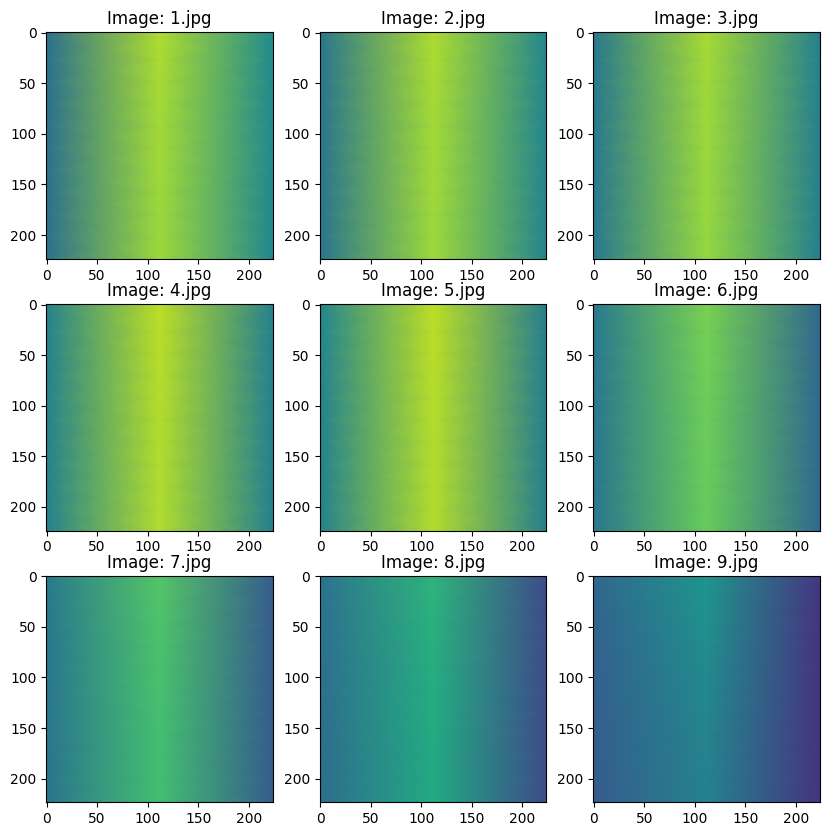

In [22]:
plot_sample_spectrograms(approach=1, output_dir='spectrogram_images/approach1/train')

## **Approach 2: Concatenating Different Time Windows (5,10,15,20,25,30)**

In [23]:
make_spectrogram_dataset(approach=2, output_dir_train='spectrogram_images/approach2/train', output_dir_test='spectrogram_images/approach2/test', number_of_days=number_of_days)

Processed 0/1291 windows
Processed 100/1291 windows
Processed 200/1291 windows
Processed 300/1291 windows
Processed 400/1291 windows
Processed 500/1291 windows
Processed 600/1291 windows
Processed 700/1291 windows
Processed 800/1291 windows
Processed 900/1291 windows
Processed 1000/1291 windows
Processed 1100/1291 windows
Processed 1200/1291 windows
All windows processed and stored.


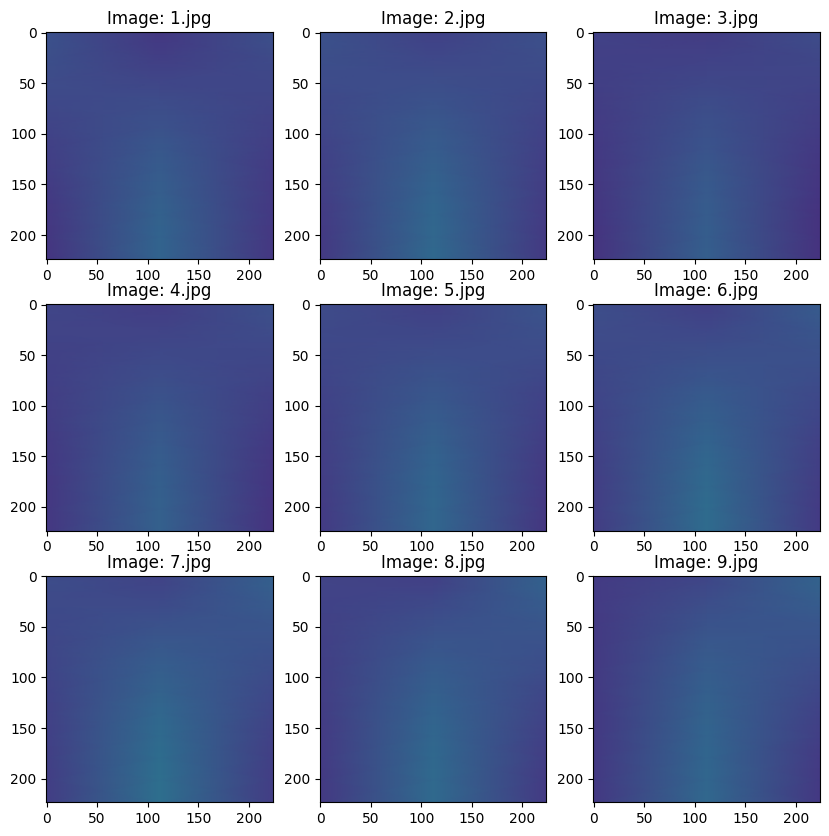

In [24]:
plot_sample_spectrograms(approach=2, output_dir='spectrogram_images/approach2/train')

## **Approach 3: Using OHLC with Volume Data**

In [25]:
make_spectrogram_dataset(approach=3, output_dir_train='spectrogram_images/approach3/train', output_dir_test='spectrogram_images/approach3/test', number_of_days=number_of_days)

Processed 0/1291 windows
Processed 100/1291 windows
Processed 200/1291 windows
Processed 300/1291 windows
Processed 400/1291 windows
Processed 500/1291 windows
Processed 600/1291 windows
Processed 700/1291 windows
Processed 800/1291 windows
Processed 900/1291 windows
Processed 1000/1291 windows
Processed 1100/1291 windows
Processed 1200/1291 windows
All windows processed and stored.


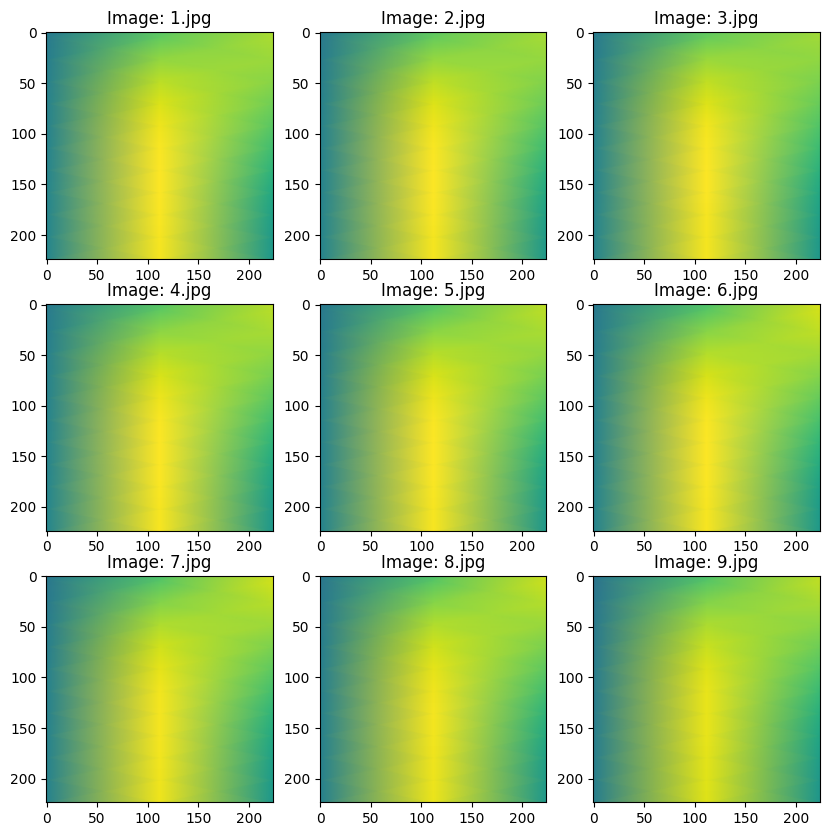

In [26]:
plot_sample_spectrograms(approach=3, output_dir='spectrogram_images/approach3/train')

# **Important Functions for Training and Results Analysis**

## **Function to Load Images**

In [27]:
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ResNet
    ])
    return transform(image)

## **Function for Training CNNs Using Mixed Precision Training**

In [28]:
def train_cnn(model_name, X_train, y_train, X_test, y_test, epochs=10, learning_rate=0.001):
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    
    # Initialize the model based on the provided model_name
    if model_name.lower() == "resnet":
        model = models.resnet50(weights=True)
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 1)
        )
    elif model_name.lower() == "alexnet":
        model = models.alexnet(weights=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 1)
    elif model_name.lower() == "densenet":
        model = models.densenet121(weights=True)
        model.classifier = nn.Linear(model.classifier.in_features, 1)
    elif model_name.lower() == "efficientnet":
        model = models.efficientnet_b0(weights=True)
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(model.classifier[1].in_features, 1)
        )
    else:
        raise ValueError("Invalid model name. Choose from 'resnet', 'alexnet', 'densenet', or 'efficientnet'.")
    
    criterion = nn.L1Loss()  # MAE loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    X_train, X_test = X_train.to(device), X_test.to(device)
    y_train, y_test = y_train.to(device), y_test.to(device)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False) 
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Lists to store MAE for each epoch
    train_mae_list = []
    test_mae_list = []

    scaler = torch.amp.GradScaler("cuda")

    train_labels_after_final_epoch = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_train_mae = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  

            with torch.amp.autocast("cuda"):  # Mixed precision training
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if(epoch == epochs - 1):
                train_labels_after_final_epoch.extend(outputs.detach().cpu().numpy())

            total_train_mae += loss.item() * len(labels)

        # Calculate average train MAE for the epoch
        avg_train_mae = total_train_mae / len(train_loader.dataset)
        train_mae_list.append(avg_train_mae)
        print(f'Epoch [{epoch + 1}/{epochs}], Train MAE: {avg_train_mae:.4f}')

        # Evaluation on test set
        model.eval()
        total_test_mae = 0.0
        outputs_test = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with torch.amp.autocast("cuda"):
                    outputs = model(inputs).squeeze()
                    loss = criterion(outputs, labels)

                total_test_mae += loss.item() * len(labels)
                outputs_test.extend(outputs.cpu().numpy())

        avg_test_mae = total_test_mae / len(test_loader.dataset)
        test_mae_list.append(avg_test_mae)
        print(f'Epoch [{epoch + 1}/{epochs}], Test MAE: {avg_test_mae:.4f}')
    
    # Return the recorded MAE values and predictions for plotting or further analysis
    return {
        "train_mae": train_mae_list,
        "test_mae": test_mae_list,
        "y_test": y_test.cpu().numpy(),
        "outputs_test": outputs_test,
        "outputs_train": train_labels_after_final_epoch
    }

## **Function to Plot the Loss Functions**

In [30]:
def plot_results(results, model, approach):
    
    plt.plot(results["train_mae"], label="Train MAE")
    plt.plot(results["test_mae"], label="Test MAE")

    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.title("Training and Testing MAE")
    plt.legend()
    plt.show()

    # save the image in a folder called spectrogram_results/approach{approach}/model_{model}

    if not os.path.exists(f"spectrogram_results/approach{approach}/{model}"):
        os.makedirs(f"spectrogram_results/approach{approach}/{model}")
    
    plt.savefig(f"spectrogram_results/approach{approach}/{model}/training_testing_mae.png")

## **Function to Predict the Price of the Stock based on the Predictions of the CNN**

In [48]:
def trend_predictions(y_true, y_pred, stock_max_rise, stock_max_fall, old_close, model, approach, actual_close_prices):
    
    predicted_prices = []
    predicted_prices.append(old_close)

    for i in range(0, len(y_pred)):

        current_val = y_pred[i]

        if(current_val > 0.5):
            new_predicted_price = old_close +  (((current_val - 0.5)*2) * stock_max_rise) 

        else:
            new_predicted_price = old_close -  (((0.5 - current_val)*2) * stock_max_fall)

        predicted_prices.append(new_predicted_price)
        old_close = new_predicted_price
    
    # plot the prices side by side on a line graph
    plt.figure(figsize=(10, 6))

    plt.plot(predicted_prices, label='Predicted Prices', color='red')
    plt.plot(actual_close_prices, label='Actual Prices', color='blue')

    plt.title('Predicted vs Actual Prices')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # plot the y_pred and y_true values on a line graph
    plt.figure(figsize=(10, 6))

    plt.plot(y_pred, label='Predicted Price Labels', color='red')
    plt.plot(y_true, label='Actual Price Labels', color='blue')

    plt.title('Predicted vs Actual Price Labels')
    plt.xlabel('Days')
    plt.ylabel('Price Label')
    plt.legend()
    plt.show()


    # Saving the plot of predicted vs actual prices
    if not os.path.exists(f"spectrogram_trend_predictions/approach{approach}/{model}"):
        os.makedirs(f"spectrogram_trend_predictions/approach{approach}/{model}")
    
    plt.savefig(f"spectrogram_trend_predictions/approach{approach}/{model}/predicted_actual_prices.png")

    # Saving the plot of predicted vs actual price labels
    if not os.path.exists(f"spectrogram_trend_predictions/approach{approach}/{model}"):
        os.makedirs(f"spectrogram_trend_predictions/approach{approach}/{model}")
    
    plt.savefig(f"spectrogram_trend_predictions/approach{approach}/{model}/predicted_actual_price_labels.png")
    
    return predicted_prices

## **Function to Store the Predictions of the CNN**

In [53]:
def store_predictions(results, model_name, approach):
    train_predictions = results["outputs_train"]
    test_predictions = results["outputs_test"]

    np.save(f"spectrogram_outputs/approach{approach}/{model_name}/train_predictions.npy", train_predictions)
    np.save(f"spectrogram_outputs/approach{approach}/{model_name}/test_predictions.npy", test_predictions)

    print(f"Predictions stored successfully in spectrogram_outputs/approach{approach}/{model_name}")

# **Getting the Training, Testing Inputs and Labels**

In [41]:
def prepare_cnn_dataset(output_dir_train, output_dir_test, train_labels, test_labels):

    X_train_paths = [os.path.join(output_dir_train, f"{i}.png") for i in range(1, len(train_labels) + 1)]
    X_test_paths = [os.path.join(output_dir_test, f"{i}.png") for i in range(1033, 1033 + len(test_labels))]

    X_train = [load_image(path) for path in X_train_paths]
    X_test = [load_image(path) for path in X_test_paths]

    print("The number of training samples is:", len(X_train))
    print("The number of testing samples is:", len(X_test))
    print("The shape of the train images is:", X_train[0].shape)
    print("The shape of the test images is:", X_test[0].shape)

    X_train = torch.stack(X_train)
    X_test = torch.stack(X_test)

    print("The shape of the training set is:", X_train.shape)
    print("The shape of the testing set is:", X_test.shape)

    return X_train, X_test

# **Loading Data, Predicting Final Trends and Storing Results**

## **Approach 1: Using a 30 day static window of Close Prices**

In [43]:
X_train_approach1, X_test_approach1 = prepare_cnn_dataset(output_dir_train='spectrogram_images/approach1/train', output_dir_test='spectrogram_images/approach1/test', train_labels=train_labels, test_labels=test_labels)

The number of training samples is: 1032
The number of testing samples is: 259
The shape of the train images is: torch.Size([3, 224, 224])
The shape of the test images is: torch.Size([3, 224, 224])
The shape of the training set is: torch.Size([1032, 3, 224, 224])
The shape of the testing set is: torch.Size([259, 3, 224, 224])


In [44]:
torch.cuda.empty_cache()

### **AlexNet**

In [45]:
alexnet_results_approach1 = train_cnn("alexnet", X_train_approach1, train_labels, X_test_approach1, test_labels, epochs=10, learning_rate=0.001)

c:\Users\Pdogg Windows10\Desktop\Semester 7\Major Project\Project\majorproject\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train MAE: 0.8372
Epoch [1/10], Test MAE: 0.0796
Epoch [2/10], Train MAE: 0.0650
Epoch [2/10], Test MAE: 0.0806
Epoch [3/10], Train MAE: 0.0617
Epoch [3/10], Test MAE: 0.0837
Epoch [4/10], Train MAE: 0.0588
Epoch [4/10], Test MAE: 0.0809
Epoch [5/10], Train MAE: 0.0591
Epoch [5/10], Test MAE: 0.0800
Epoch [6/10], Train MAE: 0.0583
Epoch [6/10], Test MAE: 0.0806
Epoch [7/10], Train MAE: 0.0583
Epoch [7/10], Test MAE: 0.0821
Epoch [8/10], Train MAE: 0.0587
Epoch [8/10], Test MAE: 0.0814
Epoch [9/10], Train MAE: 0.0584
Epoch [9/10], Test MAE: 0.0846
Epoch [10/10], Train MAE: 0.0578
Epoch [10/10], Test MAE: 0.0827


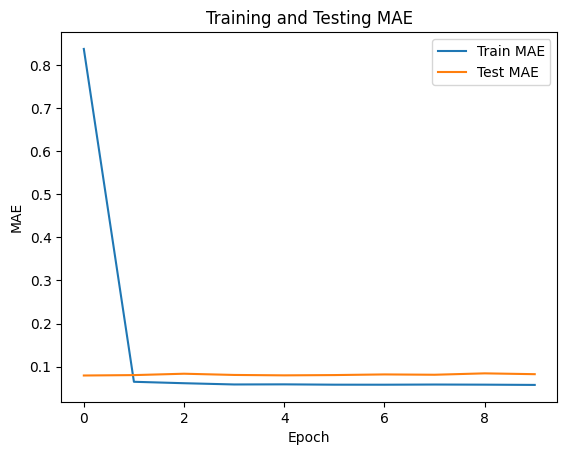

<Figure size 640x480 with 0 Axes>

In [46]:
plot_results(alexnet_results_approach1, model="alexnet", approach=1)

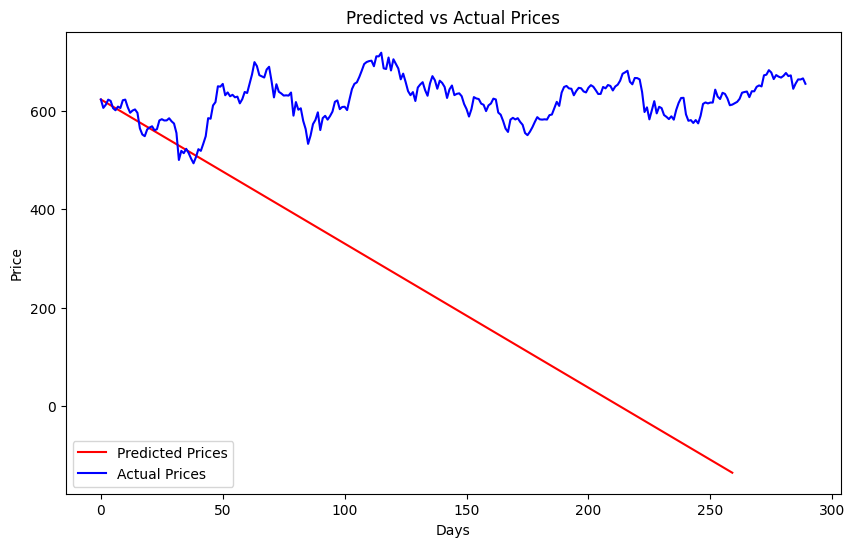

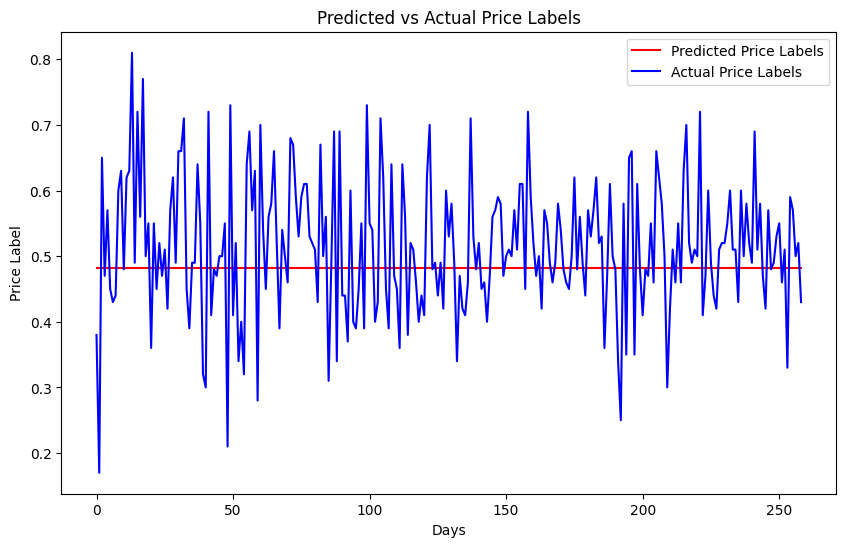

<Figure size 640x480 with 0 Axes>

In [49]:
predicted_prices_alexnet_approach1= trend_predictions(alexnet_results_approach1["y_test"], alexnet_results_approach1["outputs_test"], aubank_max_rise, aubank_max_fall, old_close, model="alexnet", approach=1, actual_close_prices=actual_close_prices)

In [54]:
store_predictions(alexnet_results_approach1, model_name="alexnet", approach=1)

Predictions stored successfully in spectrogram_outputs/approach1/alexnet


### **ResNet**

In [55]:
resnet_results_approach1 = train_cnn("resnet", X_train_approach1, train_labels, X_test_approach1, test_labels, epochs=10, learning_rate=0.001)

c:\Users\Pdogg Windows10\Desktop\Semester 7\Major Project\Project\majorproject\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train MAE: 0.2520
Epoch [1/10], Test MAE: 0.1134
Epoch [2/10], Train MAE: 0.0908
Epoch [2/10], Test MAE: 0.1327
Epoch [3/10], Train MAE: 0.0892
Epoch [3/10], Test MAE: 0.1073
Epoch [4/10], Train MAE: 0.0747
Epoch [4/10], Test MAE: 0.2098
Epoch [5/10], Train MAE: 0.0693
Epoch [5/10], Test MAE: 0.0795
Epoch [6/10], Train MAE: 0.0786
Epoch [6/10], Test MAE: 0.0841
Epoch [7/10], Train MAE: 0.0754
Epoch [7/10], Test MAE: 0.2140
Epoch [8/10], Train MAE: 0.0698
Epoch [8/10], Test MAE: 0.1967
Epoch [9/10], Train MAE: 0.0657
Epoch [9/10], Test MAE: 0.2279
Epoch [10/10], Train MAE: 0.0623
Epoch [10/10], Test MAE: 0.0795


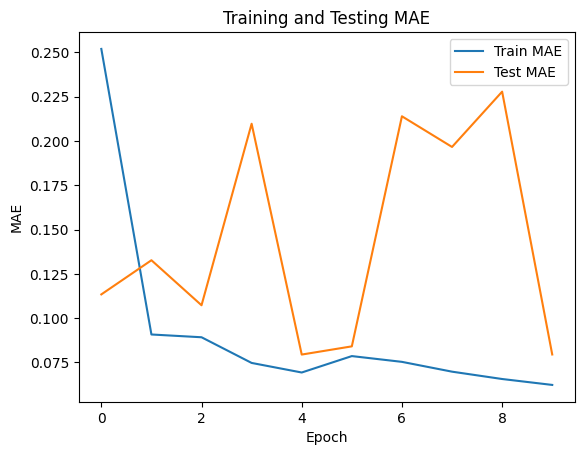

<Figure size 640x480 with 0 Axes>

In [56]:
plot_results(resnet_results_approach1, model="resnet", approach=1)

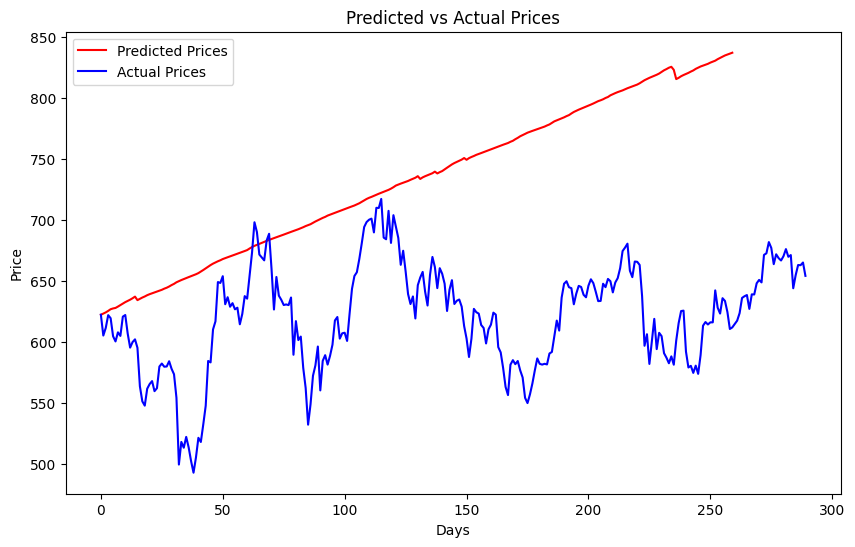

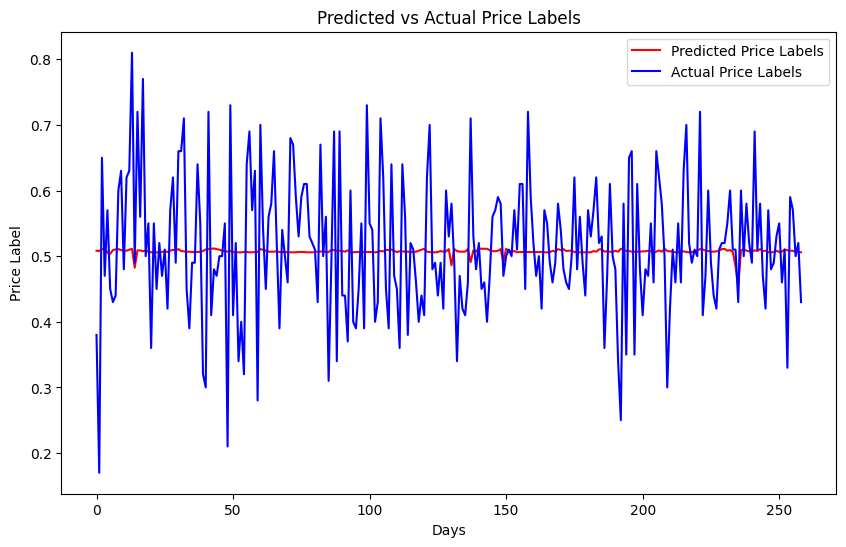

<Figure size 640x480 with 0 Axes>

In [57]:
predicted_prices_resnet_approach1 = trend_predictions(resnet_results_approach1["y_test"], resnet_results_approach1["outputs_test"], aubank_max_rise, aubank_max_fall, old_close, model="resnet", approach=1, actual_close_prices=actual_close_prices)

In [58]:
store_predictions(resnet_results_approach1, model_name="resnet", approach=1)

Predictions stored successfully in spectrogram_outputs/approach1/resnet


### **DenseNet**

In [59]:
densenet_results_approach1 = train_cnn("densenet", X_train_approach1, train_labels, X_test_approach1, test_labels, epochs=10, learning_rate=0.001)

c:\Users\Pdogg Windows10\Desktop\Semester 7\Major Project\Project\majorproject\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train MAE: 0.2622
Epoch [1/10], Test MAE: 0.1950
Epoch [2/10], Train MAE: 0.0842
Epoch [2/10], Test MAE: 0.1042
Epoch [3/10], Train MAE: 0.0720
Epoch [3/10], Test MAE: 0.1290
Epoch [4/10], Train MAE: 0.0684
Epoch [4/10], Test MAE: 0.1565
Epoch [5/10], Train MAE: 0.0903
Epoch [5/10], Test MAE: 0.0912
Epoch [6/10], Train MAE: 0.0723
Epoch [6/10], Test MAE: 0.0808
Epoch [7/10], Train MAE: 0.0658
Epoch [7/10], Test MAE: 0.0810
Epoch [8/10], Train MAE: 0.0600
Epoch [8/10], Test MAE: 0.0808
Epoch [9/10], Train MAE: 0.0618
Epoch [9/10], Test MAE: 0.0855
Epoch [10/10], Train MAE: 0.0612
Epoch [10/10], Test MAE: 0.0803


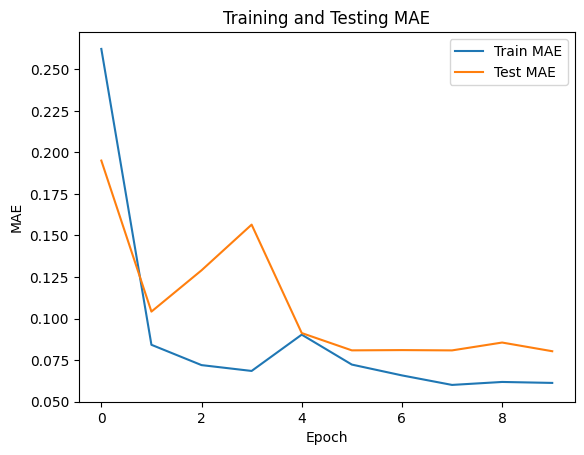

<Figure size 640x480 with 0 Axes>

In [60]:
plot_results(densenet_results_approach1, model="densenet", approach=1)

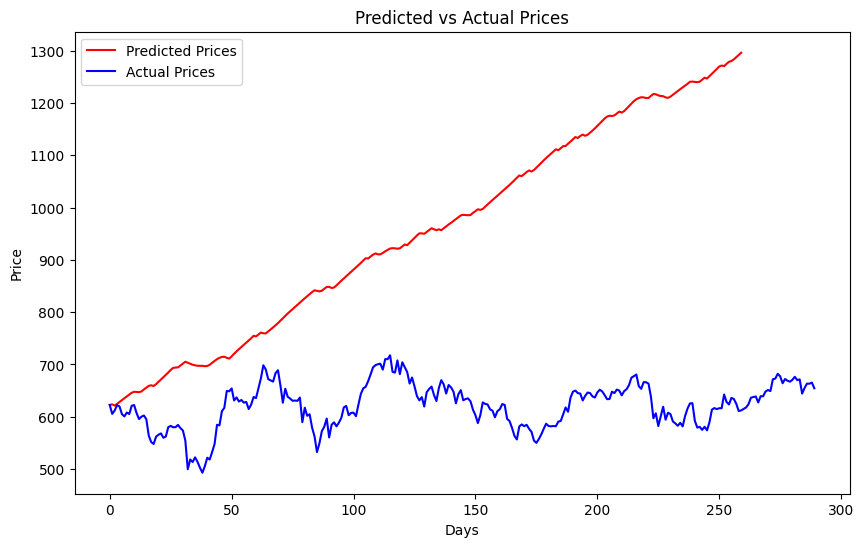

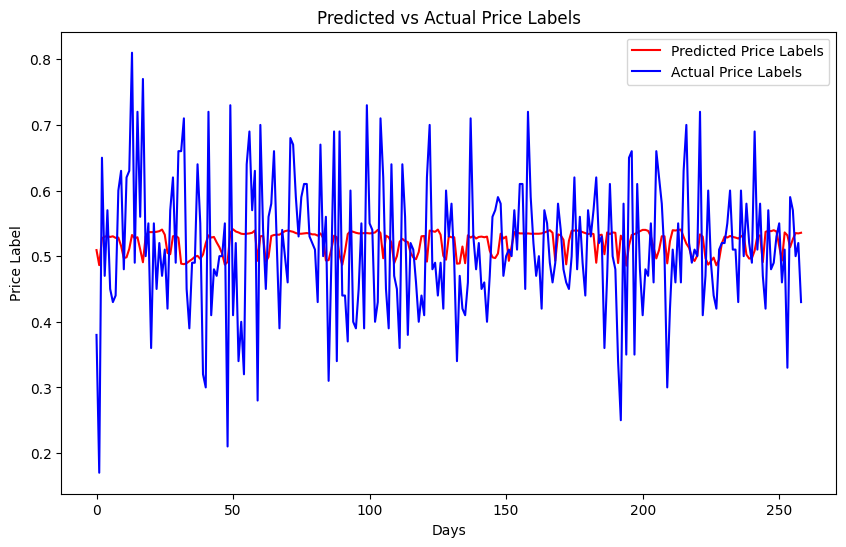

<Figure size 640x480 with 0 Axes>

In [61]:
predicted_prices_densenet_approach1 = trend_predictions(densenet_results_approach1["y_test"], densenet_results_approach1["outputs_test"], aubank_max_rise, aubank_max_fall, old_close, model="densenet", approach=1, actual_close_prices=actual_close_prices)

In [62]:
store_predictions(densenet_results_approach1, model_name="densenet", approach=1)

Predictions stored successfully in spectrogram_outputs/approach1/densenet


### **EfficientNet**

In [63]:
efficientnet_results_approach1 = train_cnn("efficientnet", X_train_approach1, train_labels, X_test_approach1, test_labels, epochs=10, learning_rate=0.001)

c:\Users\Pdogg Windows10\Desktop\Semester 7\Major Project\Project\majorproject\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train MAE: 0.1896
Epoch [1/10], Test MAE: 0.1091
Epoch [2/10], Train MAE: 0.0884
Epoch [2/10], Test MAE: 0.0863
Epoch [3/10], Train MAE: 0.0774
Epoch [3/10], Test MAE: 0.0899
Epoch [4/10], Train MAE: 0.0719
Epoch [4/10], Test MAE: 0.0871
Epoch [5/10], Train MAE: 0.0667
Epoch [5/10], Test MAE: 0.1016
Epoch [6/10], Train MAE: 0.0739
Epoch [6/10], Test MAE: 0.0851
Epoch [7/10], Train MAE: 0.0590
Epoch [7/10], Test MAE: 0.0883
Epoch [8/10], Train MAE: 0.0576
Epoch [8/10], Test MAE: 0.0856
Epoch [9/10], Train MAE: 0.0514
Epoch [9/10], Test MAE: 0.1006
Epoch [10/10], Train MAE: 0.0510
Epoch [10/10], Test MAE: 0.1429


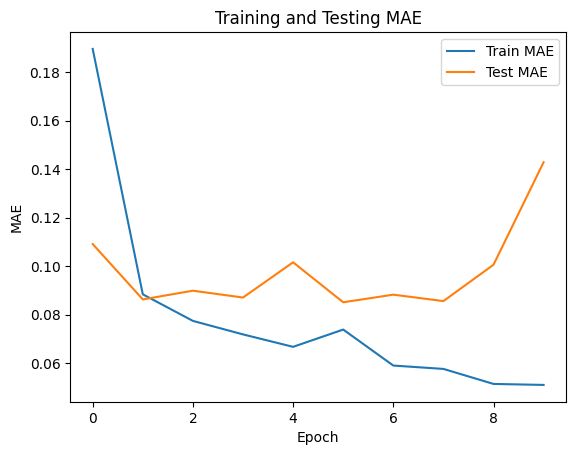

<Figure size 640x480 with 0 Axes>

In [64]:
plot_results(efficientnet_results_approach1, model="efficientnet", approach=1)

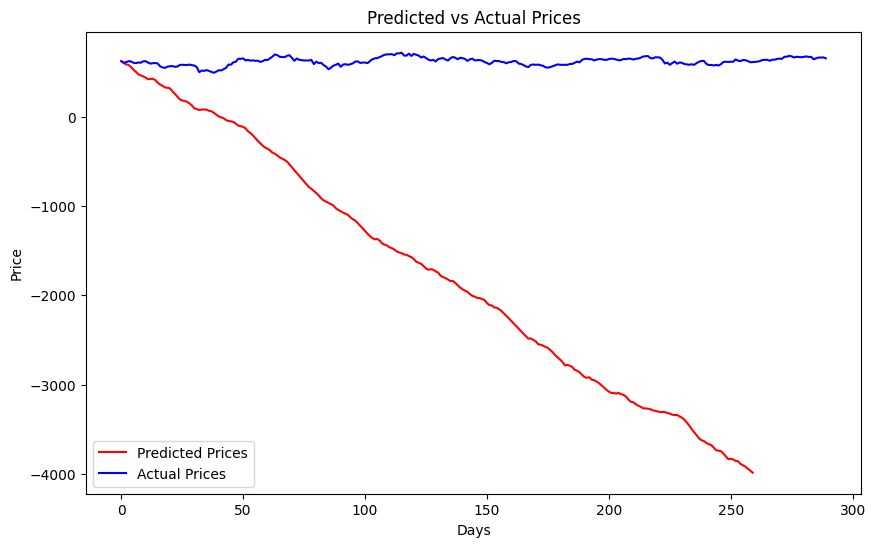

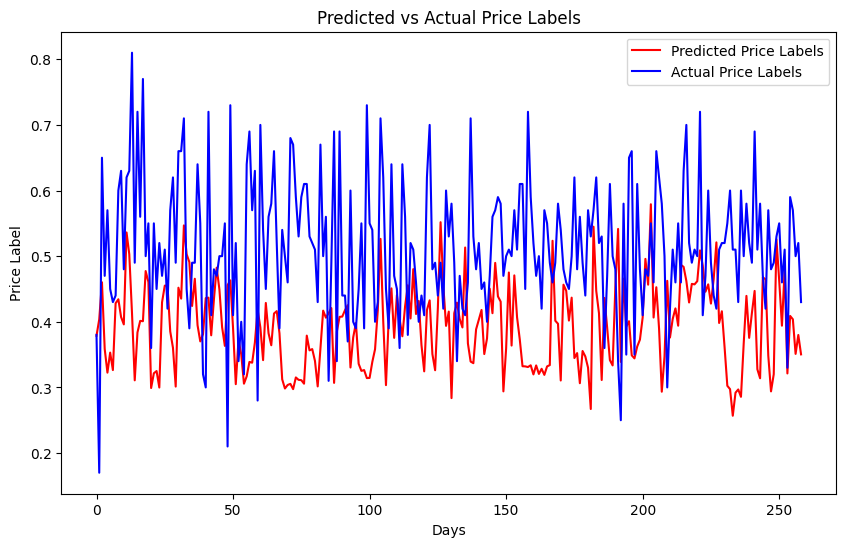

<Figure size 640x480 with 0 Axes>

In [65]:
predicted_results_efficientnet_approach1 = trend_predictions(efficientnet_results_approach1["y_test"], efficientnet_results_approach1["outputs_test"], aubank_max_rise, aubank_max_fall, old_close, model="efficientnet", approach=1, actual_close_prices=actual_close_prices)

In [66]:
store_predictions(efficientnet_results_approach1, model_name="efficientnet", approach=1)

Predictions stored successfully in spectrogram_outputs/approach1/efficientnet


## **Approach 2: Concatenating Different Time Windows (5,10,15,20,25,30)**

In [67]:
torch.cuda.empty_cache()

In [68]:
X_train_approach2, X_test_approach2 = prepare_cnn_dataset(output_dir_train='spectrogram_images/approach2/train', output_dir_test='spectrogram_images/approach2/test', train_labels=train_labels, test_labels=test_labels)

The number of training samples is: 1032
The number of testing samples is: 259
The shape of the train images is: torch.Size([3, 224, 224])
The shape of the test images is: torch.Size([3, 224, 224])
The shape of the training set is: torch.Size([1032, 3, 224, 224])
The shape of the testing set is: torch.Size([259, 3, 224, 224])


### **AlexNet**

In [69]:
alexnet_results_approach2 = train_cnn("alexnet", X_train_approach2, train_labels, X_test_approach2, test_labels, epochs=10, learning_rate=0.001)

Epoch [1/10], Train MAE: 0.6076
Epoch [1/10], Test MAE: 0.0811
Epoch [2/10], Train MAE: 0.0592
Epoch [2/10], Test MAE: 0.0796
Epoch [3/10], Train MAE: 0.0579
Epoch [3/10], Test MAE: 0.0808
Epoch [4/10], Train MAE: 0.0590
Epoch [4/10], Test MAE: 0.0805
Epoch [5/10], Train MAE: 0.0599
Epoch [5/10], Test MAE: 0.0829
Epoch [6/10], Train MAE: 0.0574
Epoch [6/10], Test MAE: 0.0796
Epoch [7/10], Train MAE: 0.0577
Epoch [7/10], Test MAE: 0.0796
Epoch [8/10], Train MAE: 0.0593
Epoch [8/10], Test MAE: 0.0808
Epoch [9/10], Train MAE: 0.0595
Epoch [9/10], Test MAE: 0.0801
Epoch [10/10], Train MAE: 0.0580
Epoch [10/10], Test MAE: 0.0811


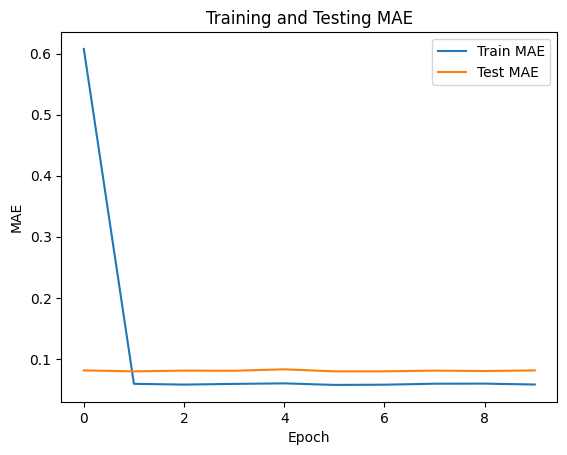

<Figure size 640x480 with 0 Axes>

In [70]:
plot_results(alexnet_results_approach2, model="alexnet", approach=2)

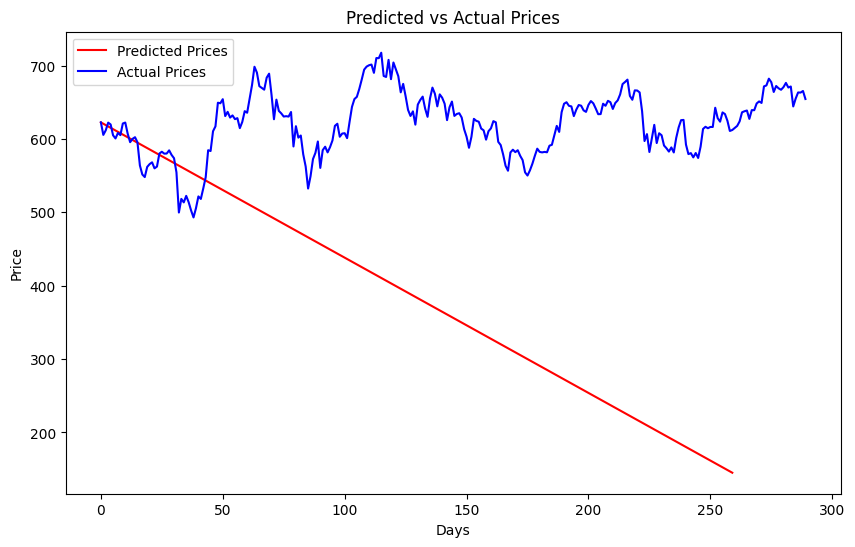

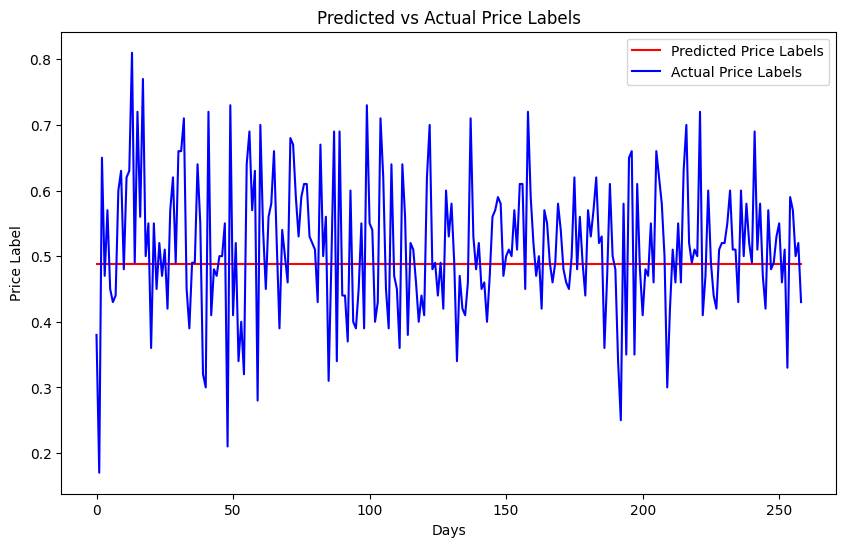

<Figure size 640x480 with 0 Axes>

In [71]:
predicted_prices_alexnet_approach2 = trend_predictions(alexnet_results_approach2["y_test"], alexnet_results_approach2["outputs_test"], aubank_max_rise, aubank_max_fall, old_close, model="alexnet", approach=2, actual_close_prices=actual_close_prices)

In [72]:
store_predictions(alexnet_results_approach2, model_name="alexnet", approach=2)

Predictions stored successfully in spectrogram_outputs/approach2/alexnet


### **ResNet**

In [73]:
resnet_results_approach2 = train_cnn("resnet", X_train_approach2, train_labels, X_test_approach2, test_labels, epochs=10, learning_rate=0.001)

Epoch [1/10], Train MAE: 0.2546
Epoch [1/10], Test MAE: 0.1345
Epoch [2/10], Train MAE: 0.0839
Epoch [2/10], Test MAE: 0.7493
Epoch [3/10], Train MAE: 0.0874
Epoch [3/10], Test MAE: 0.1012
Epoch [4/10], Train MAE: 0.0831
Epoch [4/10], Test MAE: 0.0922
Epoch [5/10], Train MAE: 0.0755
Epoch [5/10], Test MAE: 0.1596
Epoch [6/10], Train MAE: 0.0719
Epoch [6/10], Test MAE: 0.4641
Epoch [7/10], Train MAE: 0.0655
Epoch [7/10], Test MAE: 0.0832
Epoch [8/10], Train MAE: 0.0616
Epoch [8/10], Test MAE: 0.2539
Epoch [9/10], Train MAE: 0.0579
Epoch [9/10], Test MAE: 0.0836
Epoch [10/10], Train MAE: 0.0563
Epoch [10/10], Test MAE: 0.0830


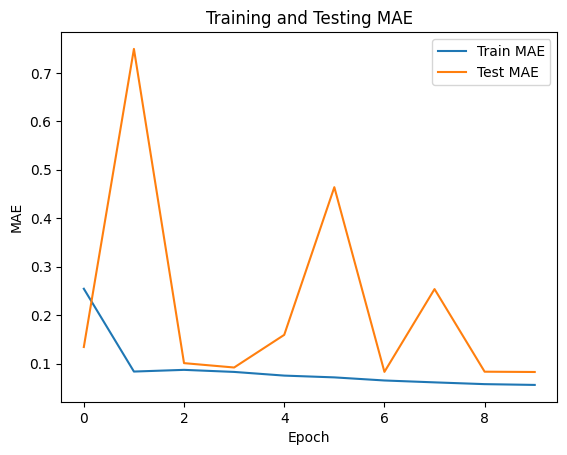

<Figure size 640x480 with 0 Axes>

In [74]:
plot_results(resnet_results_approach2, model="resnet", approach=2)

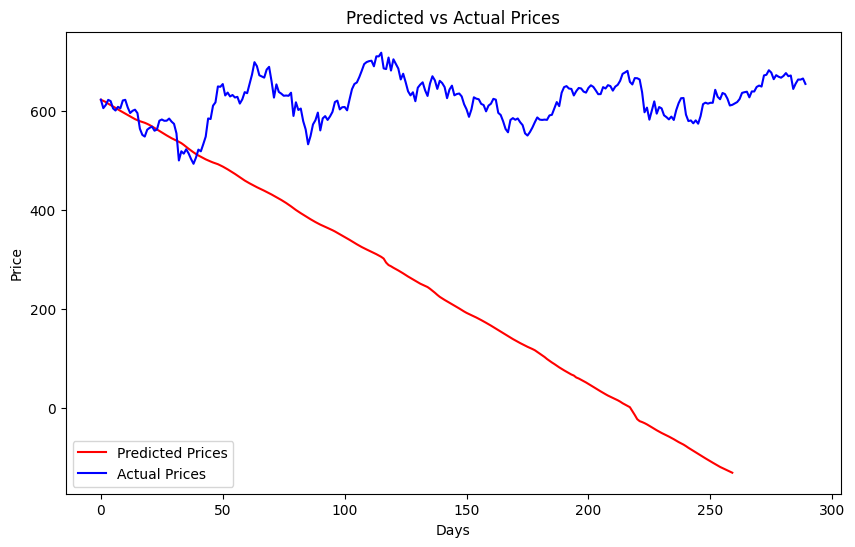

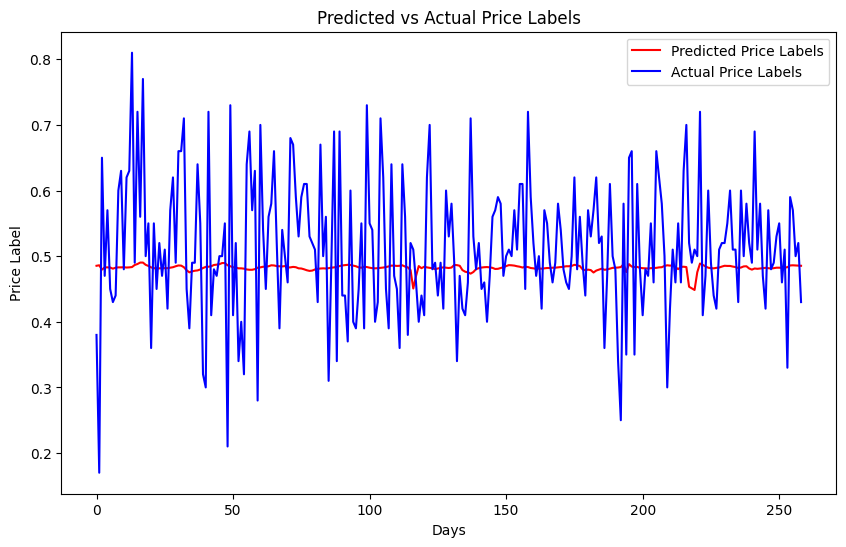

<Figure size 640x480 with 0 Axes>

In [75]:
predicted_prices_resnet_approach2 = trend_predictions(resnet_results_approach2["y_test"], resnet_results_approach2["outputs_test"], aubank_max_rise, aubank_max_fall, old_close, model="resnet", approach=2, actual_close_prices=actual_close_prices)

In [76]:
store_predictions(resnet_results_approach2, model_name="resnet", approach=2)

Predictions stored successfully in spectrogram_outputs/approach2/resnet


### **DenseNet**

In [77]:
densenet_results_approach2 = train_cnn("densenet", X_train_approach2, train_labels, X_test_approach2, test_labels, epochs=10, learning_rate=0.001)

Epoch [1/10], Train MAE: 0.2417
Epoch [1/10], Test MAE: 0.0930
Epoch [2/10], Train MAE: 0.0901
Epoch [2/10], Test MAE: 0.1006
Epoch [3/10], Train MAE: 0.0777
Epoch [3/10], Test MAE: 0.1272
Epoch [4/10], Train MAE: 0.0700
Epoch [4/10], Test MAE: 0.0854
Epoch [5/10], Train MAE: 0.0763
Epoch [5/10], Test MAE: 0.1075
Epoch [6/10], Train MAE: 0.0708
Epoch [6/10], Test MAE: 0.0841
Epoch [7/10], Train MAE: 0.0776
Epoch [7/10], Test MAE: 0.0869
Epoch [8/10], Train MAE: 0.0669
Epoch [8/10], Test MAE: 0.0844
Epoch [9/10], Train MAE: 0.0632
Epoch [9/10], Test MAE: 0.0835
Epoch [10/10], Train MAE: 0.0757
Epoch [10/10], Test MAE: 0.0820


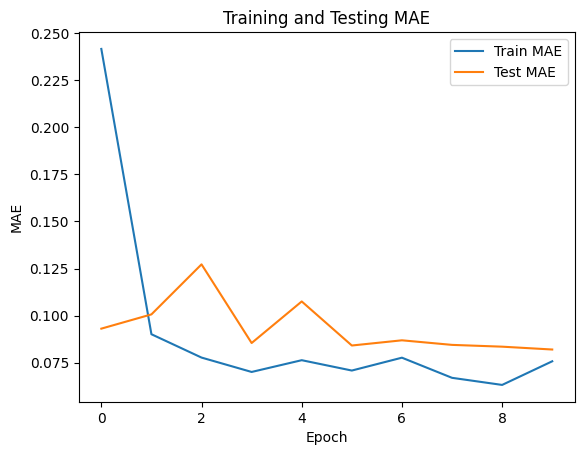

<Figure size 640x480 with 0 Axes>

In [78]:
plot_results(densenet_results_approach2, model="densenet", approach=2)

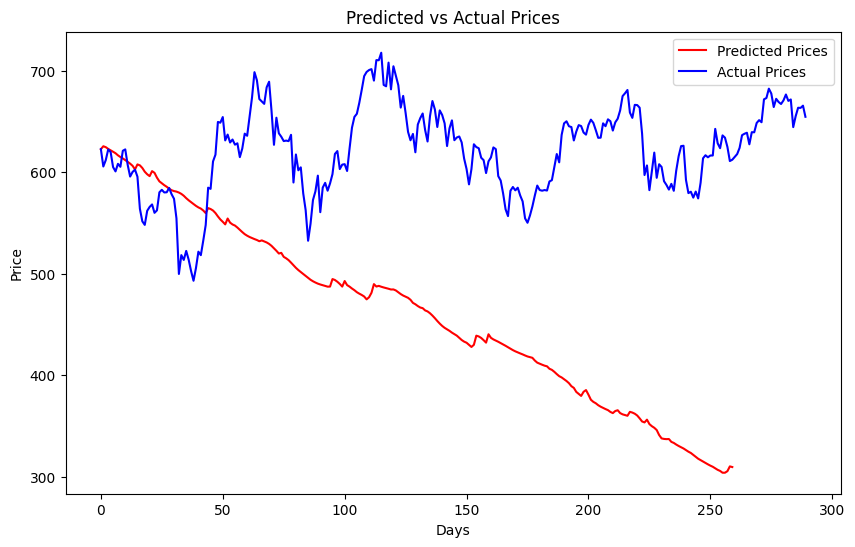

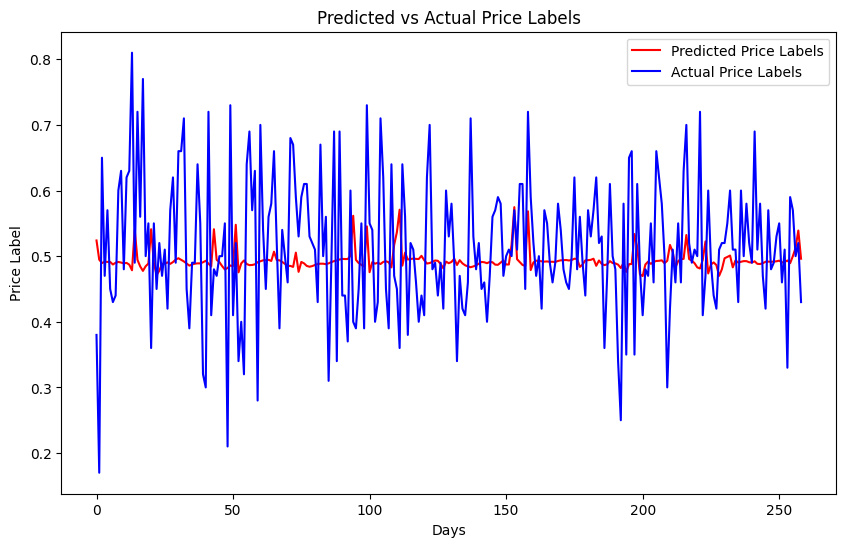

<Figure size 640x480 with 0 Axes>

In [79]:
predicted_prices_densenet_approach2 = trend_predictions(densenet_results_approach2["y_test"], densenet_results_approach2["outputs_test"], aubank_max_rise, aubank_max_fall, old_close, model="densenet", approach=2, actual_close_prices=actual_close_prices)

In [80]:
store_predictions(densenet_results_approach2, model_name="densenet", approach=2)

Predictions stored successfully in spectrogram_outputs/approach2/densenet


### **EfficientNet**

In [81]:
efficientnet_results_approach2 = train_cnn("efficientnet", X_train_approach2, train_labels, X_test_approach2, test_labels, epochs=10, learning_rate=0.001)

Epoch [1/10], Train MAE: 0.1948
Epoch [1/10], Test MAE: 0.1014
Epoch [2/10], Train MAE: 0.0843
Epoch [2/10], Test MAE: 0.0894
Epoch [3/10], Train MAE: 0.0698
Epoch [3/10], Test MAE: 0.0831
Epoch [4/10], Train MAE: 0.0686
Epoch [4/10], Test MAE: 0.0906
Epoch [5/10], Train MAE: 0.0720
Epoch [5/10], Test MAE: 0.0983
Epoch [6/10], Train MAE: 0.0656
Epoch [6/10], Test MAE: 0.0932
Epoch [7/10], Train MAE: 0.0582
Epoch [7/10], Test MAE: 0.0906
Epoch [8/10], Train MAE: 0.0570
Epoch [8/10], Test MAE: 0.0840
Epoch [9/10], Train MAE: 0.0555
Epoch [9/10], Test MAE: 0.0933
Epoch [10/10], Train MAE: 0.0507
Epoch [10/10], Test MAE: 0.1028


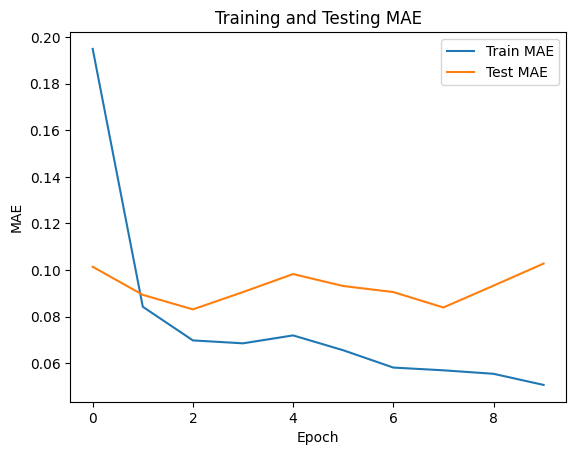

<Figure size 640x480 with 0 Axes>

In [82]:
plot_results(efficientnet_results_approach2, model="efficientnet", approach=2)

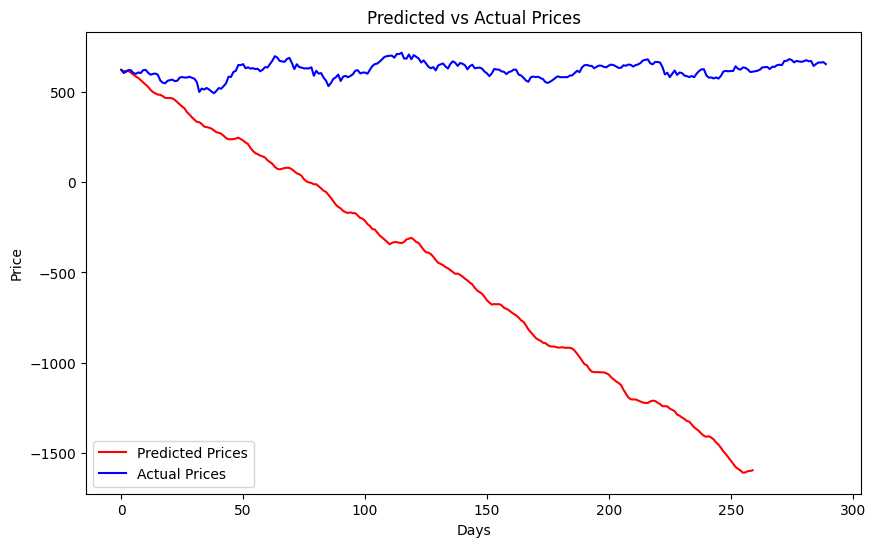

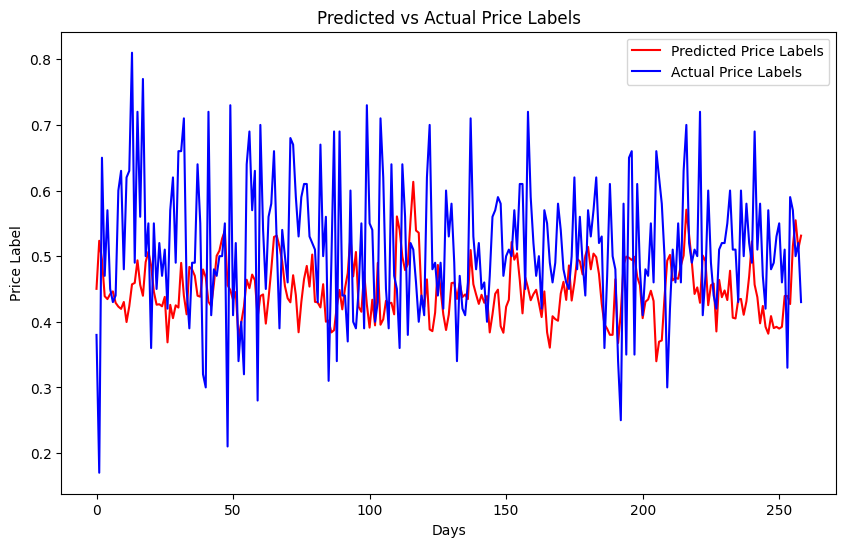

<Figure size 640x480 with 0 Axes>

In [83]:
predicted_results_efficientnet_approach2 = trend_predictions(efficientnet_results_approach2["y_test"], efficientnet_results_approach2["outputs_test"], aubank_max_rise, aubank_max_fall, old_close, model="efficientnet", approach=2, actual_close_prices=actual_close_prices)

In [84]:
store_predictions(efficientnet_results_approach2, model_name="efficientnet", approach=2)

Predictions stored successfully in spectrogram_outputs/approach2/efficientnet


## **Approach 3: Using OHLC with Volume Data**

In [85]:
torch.cuda.empty_cache()

In [86]:
X_train_approach3, X_test_approach3 = prepare_cnn_dataset(output_dir_train='spectrogram_images/approach3/train', output_dir_test='spectrogram_images/approach3/test', train_labels=train_labels, test_labels=test_labels)

The number of training samples is: 1032
The number of testing samples is: 259
The shape of the train images is: torch.Size([3, 224, 224])
The shape of the test images is: torch.Size([3, 224, 224])
The shape of the training set is: torch.Size([1032, 3, 224, 224])
The shape of the testing set is: torch.Size([259, 3, 224, 224])


### **AlexNet**

In [87]:
alexnet_results_approach3 = train_cnn("alexnet", X_train_approach3, train_labels, X_test_approach3, test_labels, epochs=10, learning_rate=0.001)

Epoch [1/10], Train MAE: 0.5024
Epoch [1/10], Test MAE: 0.0830
Epoch [2/10], Train MAE: 0.0647
Epoch [2/10], Test MAE: 0.0808
Epoch [3/10], Train MAE: 0.0603
Epoch [3/10], Test MAE: 0.0835
Epoch [4/10], Train MAE: 0.0584
Epoch [4/10], Test MAE: 0.0835
Epoch [5/10], Train MAE: 0.0601
Epoch [5/10], Test MAE: 0.0802
Epoch [6/10], Train MAE: 0.0577
Epoch [6/10], Test MAE: 0.0796
Epoch [7/10], Train MAE: 0.0577
Epoch [7/10], Test MAE: 0.0815
Epoch [8/10], Train MAE: 0.0603
Epoch [8/10], Test MAE: 0.0804
Epoch [9/10], Train MAE: 0.0559
Epoch [9/10], Test MAE: 0.0796
Epoch [10/10], Train MAE: 0.0580
Epoch [10/10], Test MAE: 0.0804


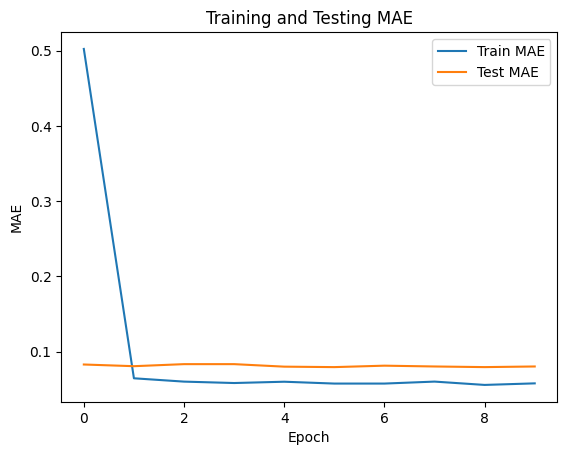

<Figure size 640x480 with 0 Axes>

In [88]:
plot_results(alexnet_results_approach3, model="alexnet", approach=3)

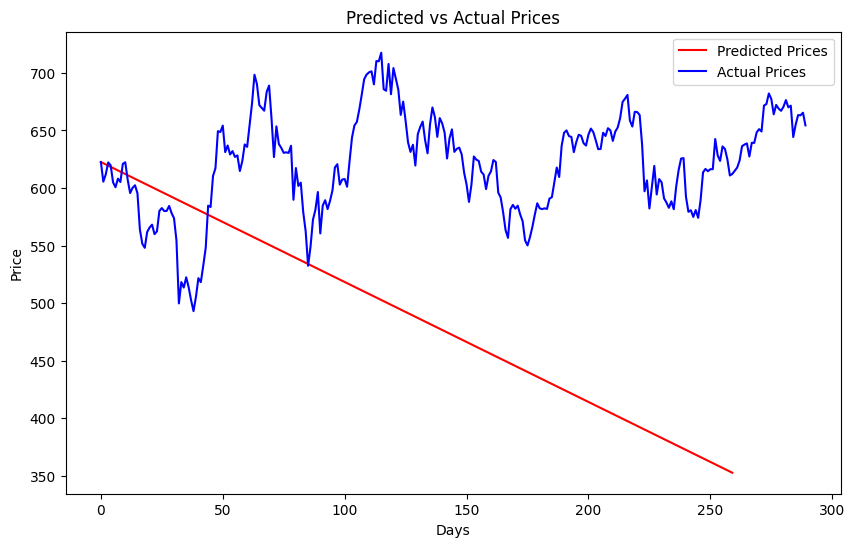

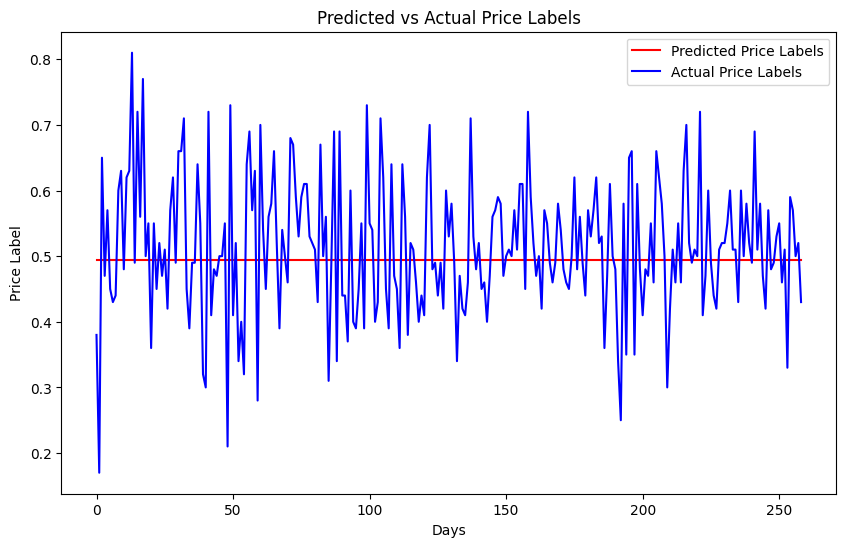

<Figure size 640x480 with 0 Axes>

In [89]:
predicted_prices_alexnet_approach3 = trend_predictions(alexnet_results_approach3["y_test"], alexnet_results_approach3["outputs_test"], aubank_max_rise, aubank_max_fall, old_close, model="alexnet", approach=3, actual_close_prices=actual_close_prices)

In [90]:
store_predictions(alexnet_results_approach3, model_name="alexnet", approach=3)

Predictions stored successfully in spectrogram_outputs/approach3/alexnet


### **ResNet**

In [91]:
resnet_results_approach3 = train_cnn("resnet", X_train_approach3, train_labels, X_test_approach3, test_labels, epochs=10, learning_rate=0.001)

Epoch [1/10], Train MAE: 0.1890
Epoch [1/10], Test MAE: 0.1790
Epoch [2/10], Train MAE: 0.1370
Epoch [2/10], Test MAE: 0.3101
Epoch [3/10], Train MAE: 0.0893
Epoch [3/10], Test MAE: 0.1223
Epoch [4/10], Train MAE: 0.0915
Epoch [4/10], Test MAE: 0.1045
Epoch [5/10], Train MAE: 0.0641
Epoch [5/10], Test MAE: 0.0819
Epoch [6/10], Train MAE: 0.0593
Epoch [6/10], Test MAE: 0.0922
Epoch [7/10], Train MAE: 0.0607
Epoch [7/10], Test MAE: 0.1045
Epoch [8/10], Train MAE: 0.0641
Epoch [8/10], Test MAE: 0.0854
Epoch [9/10], Train MAE: 0.0586
Epoch [9/10], Test MAE: 0.0805
Epoch [10/10], Train MAE: 0.0597
Epoch [10/10], Test MAE: 0.0844


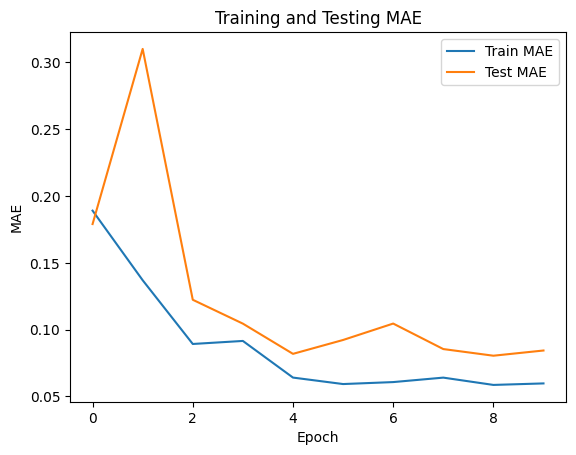

<Figure size 640x480 with 0 Axes>

In [92]:
plot_results(resnet_results_approach3, model="resnet", approach=3)

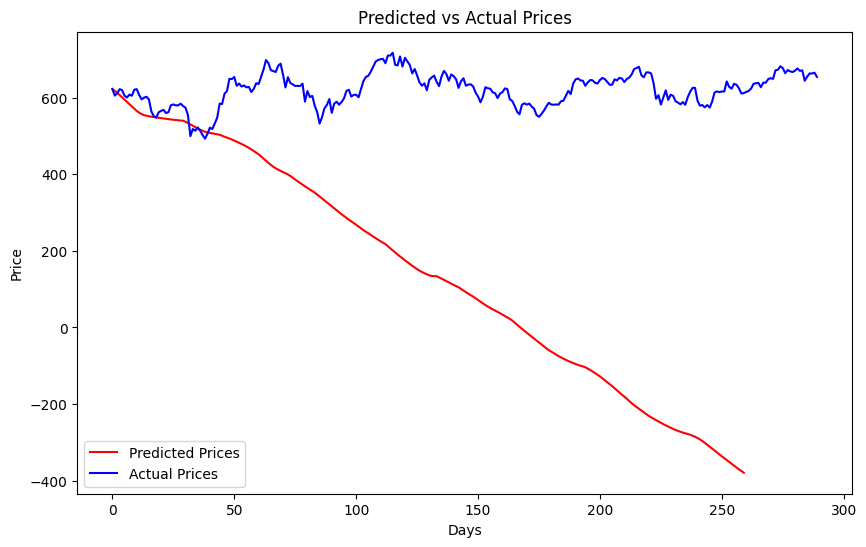

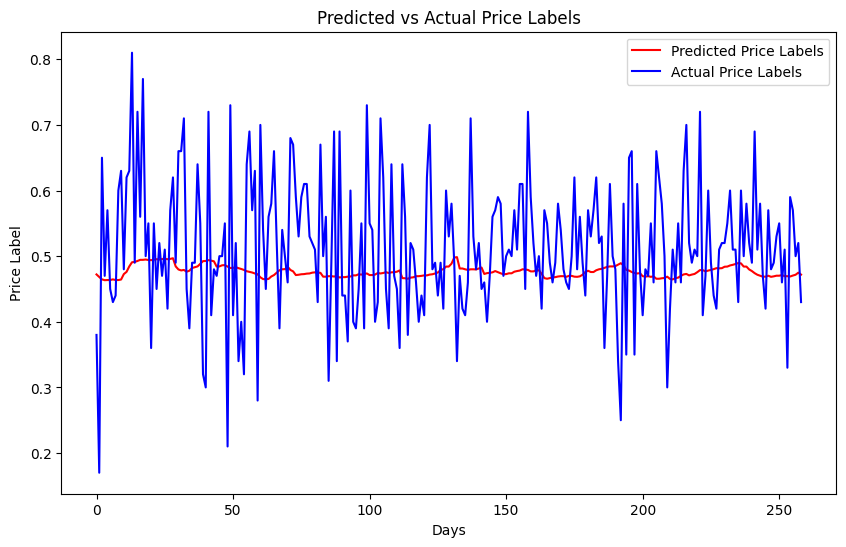

<Figure size 640x480 with 0 Axes>

In [93]:
predicted_prices_resnet_approach3 = trend_predictions(resnet_results_approach3["y_test"], resnet_results_approach3["outputs_test"], aubank_max_rise, aubank_max_fall, old_close, model="resnet", approach=3, actual_close_prices=actual_close_prices)

In [94]:
store_predictions(resnet_results_approach3, model_name="resnet", approach=3)

Predictions stored successfully in spectrogram_outputs/approach3/resnet


### **DenseNet**

In [95]:
densenet_results_approach3 = train_cnn("densenet", X_train_approach3, train_labels, X_test_approach3, test_labels, epochs=10, learning_rate=0.001)

Epoch [1/10], Train MAE: 0.1889
Epoch [1/10], Test MAE: 0.0942
Epoch [2/10], Train MAE: 0.0709
Epoch [2/10], Test MAE: 0.0824
Epoch [3/10], Train MAE: 0.0729
Epoch [3/10], Test MAE: 0.0797
Epoch [4/10], Train MAE: 0.0624
Epoch [4/10], Test MAE: 0.0832
Epoch [5/10], Train MAE: 0.0721
Epoch [5/10], Test MAE: 0.1044
Epoch [6/10], Train MAE: 0.0623
Epoch [6/10], Test MAE: 0.0907
Epoch [7/10], Train MAE: 0.0614
Epoch [7/10], Test MAE: 0.0806
Epoch [8/10], Train MAE: 0.0661
Epoch [8/10], Test MAE: 0.0807
Epoch [9/10], Train MAE: 0.0733
Epoch [9/10], Test MAE: 0.0814
Epoch [10/10], Train MAE: 0.0703
Epoch [10/10], Test MAE: 0.0908


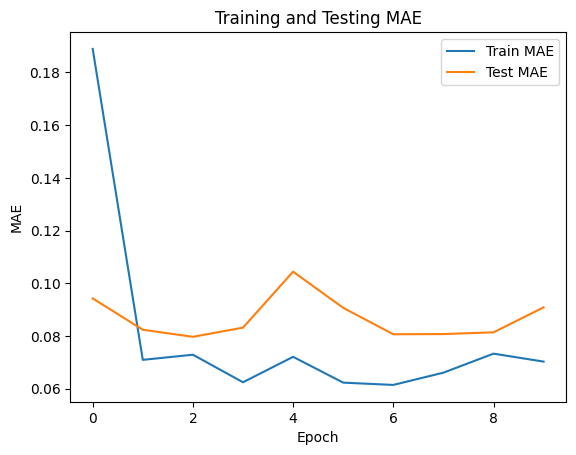

<Figure size 640x480 with 0 Axes>

In [96]:
plot_results(densenet_results_approach3, model="densenet", approach=3)

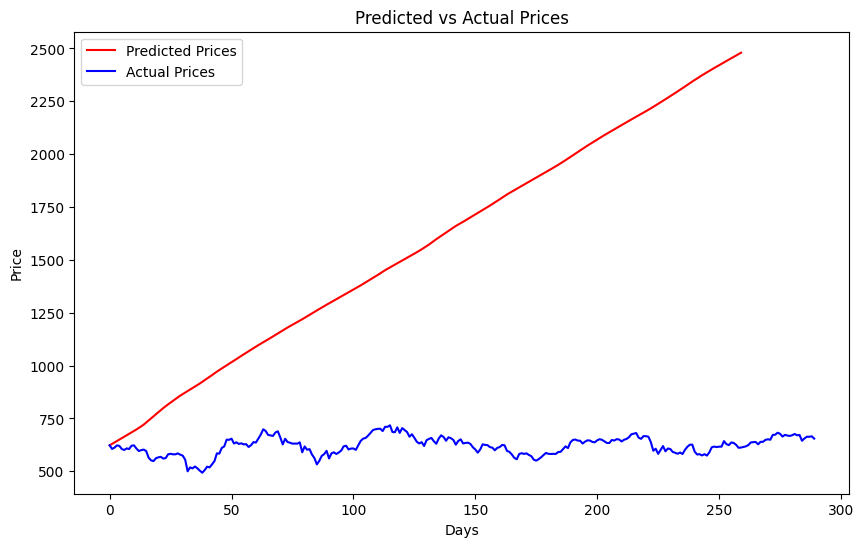

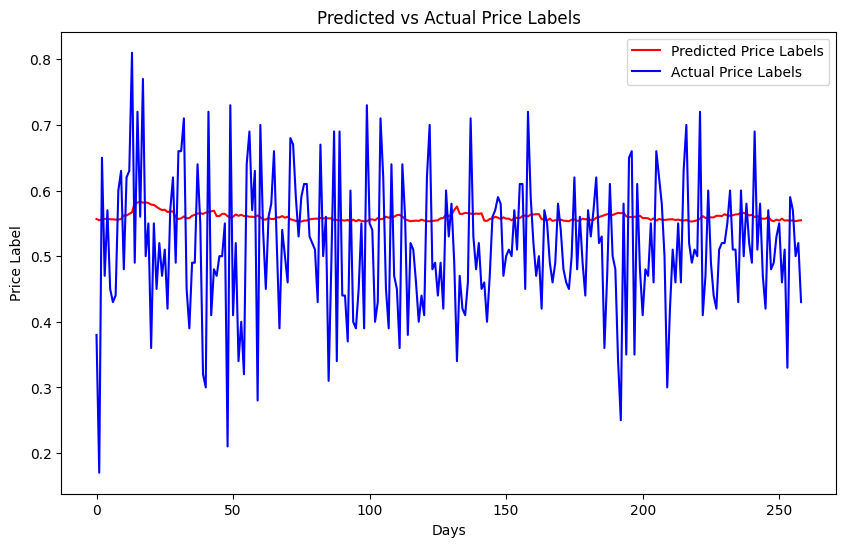

<Figure size 640x480 with 0 Axes>

In [97]:
predicted_prices_densenet_approach3 = trend_predictions(densenet_results_approach3["y_test"], densenet_results_approach3["outputs_test"], aubank_max_rise, aubank_max_fall, old_close, model="densenet", approach=3, actual_close_prices=actual_close_prices)

In [98]:
store_predictions(densenet_results_approach3, model_name="densenet", approach=3)

Predictions stored successfully in spectrogram_outputs/approach3/densenet


### **EfficientNet**

In [99]:
efficientnet_results_approach3 = train_cnn("efficientnet", X_train_approach3, train_labels, X_test_approach3, test_labels, epochs=10, learning_rate=0.001)

Epoch [1/10], Train MAE: 0.1777
Epoch [1/10], Test MAE: 0.1364
Epoch [2/10], Train MAE: 0.0735
Epoch [2/10], Test MAE: 0.0886
Epoch [3/10], Train MAE: 0.0661
Epoch [3/10], Test MAE: 0.0839
Epoch [4/10], Train MAE: 0.0612
Epoch [4/10], Test MAE: 0.0930
Epoch [5/10], Train MAE: 0.0634
Epoch [5/10], Test MAE: 0.0880
Epoch [6/10], Train MAE: 0.0628
Epoch [6/10], Test MAE: 0.0879
Epoch [7/10], Train MAE: 0.0562
Epoch [7/10], Test MAE: 0.0834
Epoch [8/10], Train MAE: 0.0578
Epoch [8/10], Test MAE: 0.0979
Epoch [9/10], Train MAE: 0.0559
Epoch [9/10], Test MAE: 0.0921
Epoch [10/10], Train MAE: 0.0543
Epoch [10/10], Test MAE: 0.0952


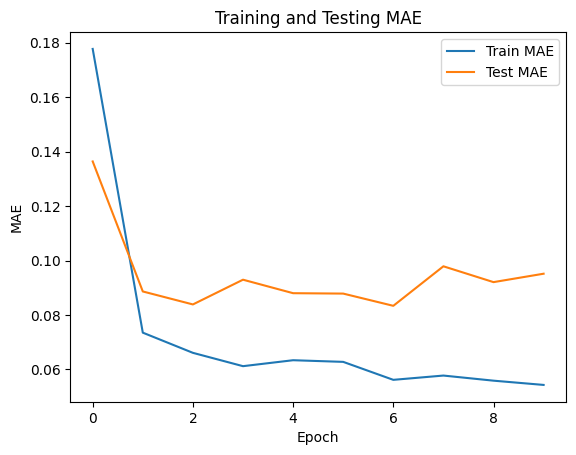

<Figure size 640x480 with 0 Axes>

In [100]:
plot_results(efficientnet_results_approach3, model="efficientnet", approach=3)

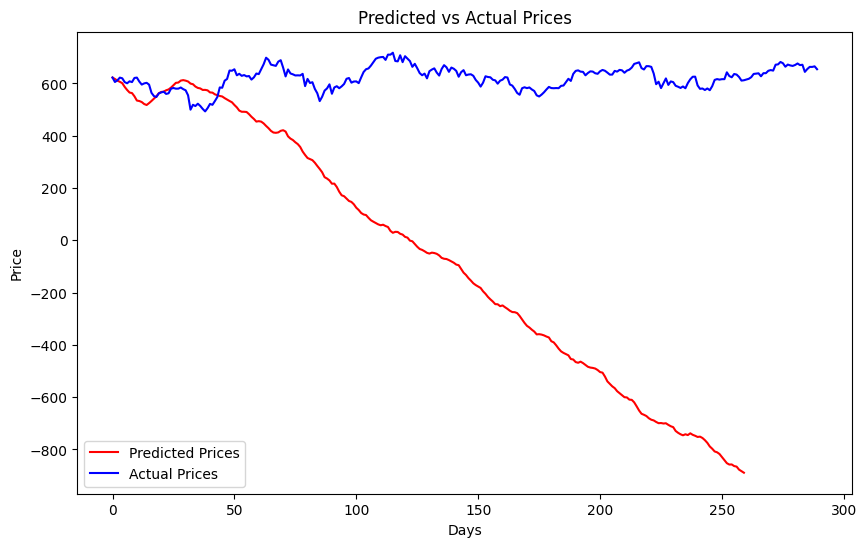

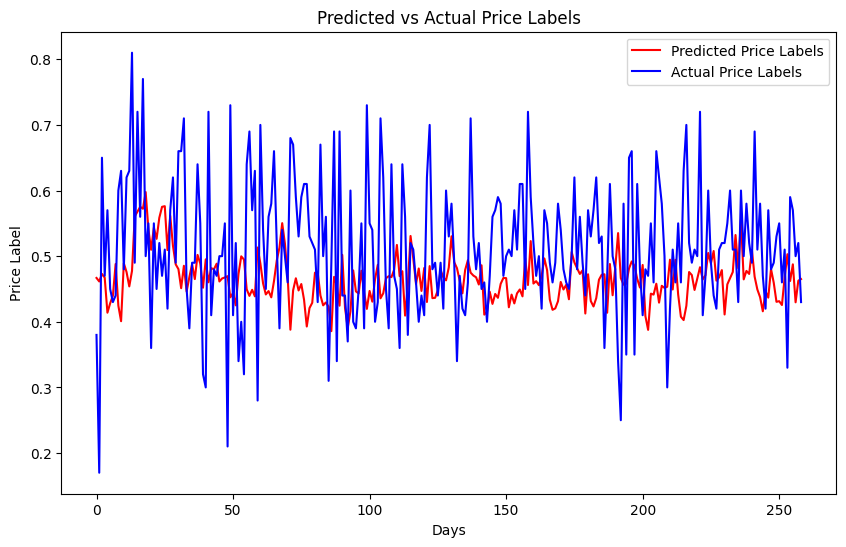

<Figure size 640x480 with 0 Axes>

In [101]:
predicted_results_efficientnet_approach3 = trend_predictions(efficientnet_results_approach3["y_test"], efficientnet_results_approach3["outputs_test"], aubank_max_rise, aubank_max_fall, old_close, model="efficientnet", approach=3, actual_close_prices=actual_close_prices)

In [102]:
store_predictions(efficientnet_results_approach3, model_name="efficientnet", approach=3)

Predictions stored successfully in spectrogram_outputs/approach3/efficientnet
